### Import Modules and Python Functions

In [1]:
import os
import numpy as np
import pandas as pd
import yaml
with open('../python/variables.yaml') as info:
    VARS = yaml.load(info, Loader=yaml.FullLoader)

#os.path.join( os.path.dirname('__file__' ), '../python' )
#from from_csv_to_df import get_select_data

### Import Variables

In [2]:
# Events
events_csv = VARS['EVENTS_CSV']
events_cols_all = VARS['EVENTS_COLS_ALL']
events_cols_select = VARS['EVENTS_COLS_SELECT']

# Mentions
mentions_csv = VARS['MENTIONS_CSV']
mentions_cols_all = VARS['MENTIONS_COLS_ALL']
mentions_cols_select = VARS['MENTIONS_COLS_SELECT']

# Pilot
cameo_codes = VARS['PILOT_CAMEO_VERB_CODES']
select_countries_60 = VARS['PILOT_COUNTRIES_IOS2']

### Define Reusable Python Functions

In [3]:
def get_select_data(filepath: str, all_cols: list, select_cols: list) -> object:
    """Get Select Columns of Data from GDELT Latest Update CSV
    :param filepath: full filename and path to CSV file to be imported
    :param all_cols: column names of the CSV imported
    :param select_cols: derivative list of columns from all_cols
    :rtype: dataframe
    :return: dataframe
    """

    # Import entire CSV
    latest_update_df = pd.DataFrame(pd.read_csv(filepath,
                                                names=all_cols,
                                                delimiter="\t"))

    # Select specific columns
    return latest_update_df[select_cols]

In [59]:
def get_var_percentages(dataframe, target_col: str) -> object:
    """Get Percentage of Column Values in Target Column of Cleaned GDELT Data
    :param dataframe: dataframe of cleaned data
    :param target_col: column name of variable of interest
    :rtype: dataframe
    :return: dataframe
    """

    # Create a sub-dataframe to group GLOBALEVENTID by Target Column
    grouped_df = cleaned_merged_df[['GLOBALEVENTID', target_col]].groupby(target_col).count()
    
    # Get variable percentage                                                                
    grouped_df['%'] = (grouped_df['GLOBALEVENTID'] / grouped_df['GLOBALEVENTID'].sum()) * 100
    
    return grouped_df

### Import Data

#### Events Data

In [4]:
# get data
e1_df = get_select_data(events_csv,
                        events_cols_all,
                        events_cols_select)

e2_df = get_select_data('../select_data/data/latest_gdelt_events_2.csv',
                        events_cols_all,
                        events_cols_select)

gdelt_se_df = pd.merge(e1_df, e2_df, on=events_cols_select, how='outer')
print(gdelt_se_df.shape)
print(gdelt_se_df.info())
gdelt_se_df.head(1)

(2506, 12)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2506 entries, 0 to 2505
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   GLOBALEVENTID          2506 non-null   int64  
 1   SQLDATE                2506 non-null   int64  
 2   EventCode              2506 non-null   int64  
 3   EventRootCode          2506 non-null   int64  
 4   QuadClass              2506 non-null   int64  
 5   GoldsteinScale         2506 non-null   float64
 6   ActionGeo_Type         2506 non-null   int64  
 7   ActionGeo_FullName     2446 non-null   object 
 8   ActionGeo_CountryCode  2448 non-null   object 
 9   ActionGeo_Lat          2446 non-null   float64
 10  ActionGeo_Long         2446 non-null   float64
 11  SOURCEURL              2506 non-null   object 
dtypes: float64(3), int64(6), object(3)
memory usage: 254.5+ KB
None


,GLOBALEVENTID,SQLDATE,EventCode,EventRootCode,QuadClass,GoldsteinScale,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_Lat,ActionGeo_Long,SOURCEURL
0,972238884,20200301,20,2,1,3.0,4,"Canberra, Australian Capital Territory, Australia",AS,-35.2833,149.217,https://www.aninews.in/news/world/asia/china-a...


In [5]:
print('Number of Global Event Ids: ', len(gdelt_se_df['GLOBALEVENTID'].unique()))

Number of Global Event Ids:  2506


In [6]:
# Assess date range
print('Min Event Date: ', gdelt_se_df['SQLDATE'].min())
print('Max Event Date: ', gdelt_se_df['SQLDATE'].max())

Min Event Date:  20200301
Max Event Date:  20210302


### Mentions Data

In [7]:
# get data
m1_df = get_select_data(mentions_csv,
                              mentions_cols_all,
                              mentions_cols_select)

m2_df = get_select_data('../select_data/data/latest_gdelt_mentions_2.csv',
                              mentions_cols_all,
                              mentions_cols_select)

gdelt_sm_df = pd.merge(m1_df, m2_df, on=mentions_cols_select, how='outer')
print(gdelt_sm_df.shape)
print(gdelt_sm_df.info())
gdelt_sm_df.head(1)

(4325, 5)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4325 entries, 0 to 4324
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   GLOBALEVENTID    4325 non-null   int64  
 1   EventTimeDate    4325 non-null   int64  
 2   MentionTimeDate  4325 non-null   int64  
 3   Confidence       4325 non-null   int64  
 4   MentionDocTone   4325 non-null   float64
dtypes: float64(1), int64(4)
memory usage: 202.7 KB
None


,GLOBALEVENTID,EventTimeDate,MentionTimeDate,Confidence,MentionDocTone
0,972238884,20210301204500,20210301204500,20,-6.52921


In [8]:
print('Number of Global Event Ids: ', len(gdelt_sm_df['GLOBALEVENTID'].unique()))

Number of Global Event Ids:  3229


In [9]:
# Assess date range
print('Min Mentions Date: ', gdelt_sm_df['MentionTimeDate'].min())
print('Max Mentions Date: ', gdelt_sm_df['MentionTimeDate'].max())

Min Mentions Date:  20210301204500
Max Mentions Date:  20210301204500


#### Select Mentions within first 60 Days of an Event

In [10]:
# Calculate days between
gdelt_sm_df['DaysBetween'] = gdelt_sm_df['MentionTimeDate'] - gdelt_sm_df['EventTimeDate']
#print(gdelt_sm_df['DaysBetween'][0])

# Drop rows where days_between <= 60 days
gdelt_sm_60d_df = gdelt_sm_df[gdelt_sm_df['DaysBetween'] <= 60].reset_index(drop=True)
print(gdelt_sm_60d_df.shape)
print('Number of Global Event Ids: ', len(gdelt_sm_60d_df['GLOBALEVENTID'].unique()))
gdelt_sm_60d_df.head()

(1324, 6)
Number of Global Event Ids:  1212


,GLOBALEVENTID,EventTimeDate,MentionTimeDate,Confidence,MentionDocTone,DaysBetween
0,972238884,20210301204500,20210301204500,20,-6.529210,0
1,972238885,20210301204500,20210301204500,20,-6.529210,0
2,972238886,20210301204500,20210301204500,60,-6.529210,0
3,972238887,20210301204500,20210301204500,40,-4.385965,0
4,972238888,20210301204500,20210301204500,40,-4.385965,0


In [11]:
# Verify output
max(gdelt_sm_60d_df['DaysBetween'])

0

#### Change int64 dates to datetimes

In [12]:
date_format = '%Y%m%d%H%M%S'
gdelt_sm_60d_df['EventTimeDate'] = pd.to_datetime(gdelt_sm_60d_df['EventTimeDate'].astype(str), format=date_format)
gdelt_sm_60d_df['MentionTimeDate'] = pd.to_datetime(gdelt_sm_60d_df['MentionTimeDate'].astype(str), format=date_format)
gdelt_sm_60d_df.head()

,GLOBALEVENTID,EventTimeDate,MentionTimeDate,Confidence,MentionDocTone,DaysBetween
0,972238884,2021-03-01 20:45:00,2021-03-01 20:45:00,20,-6.529210,0
1,972238885,2021-03-01 20:45:00,2021-03-01 20:45:00,20,-6.529210,0
2,972238886,2021-03-01 20:45:00,2021-03-01 20:45:00,60,-6.529210,0
3,972238887,2021-03-01 20:45:00,2021-03-01 20:45:00,40,-4.385965,0
4,972238888,2021-03-01 20:45:00,2021-03-01 20:45:00,40,-4.385965,0


#### Group Mentions Data by GlobalEventId for Average Confidence and Mention Tone

agg_cols = ['GLOBALEVENTID','MeanConfidence', 'MeanMentionDocTone']

gdelt_sm_60d_agg_df = gdelt_sm_60d_df.groupby(['GLOBALEVENTID', 'EventTimeDate'], as_index=False,
                                             ).mean() # get mean Confidence, Tone, DaysBetween
gdelt_sm_60d_agg_df.head()

### Join Events and Mentions Data on GlobalEventId

In [13]:
print('Events Data: ', gdelt_se_df.shape)
print('Mentions Data: ', gdelt_sm_60d_df.shape)

# Merge dataframes
merged_df = gdelt_se_df.merge(gdelt_sm_60d_df, how='left', on='GLOBALEVENTID')
print('Merged Data w/ Duplicates: ', merged_df.shape)

# Drop duplicates
merged_df = merged_df.drop_duplicates()
print('Merged Data w/o Duplicates: ',merged_df.shape)
merged_df.head()

Events Data:  (2506, 12)
Mentions Data:  (1324, 6)
Merged Data w/ Duplicates:  (2618, 17)
Merged Data w/o Duplicates:  (2595, 17)


,GLOBALEVENTID,SQLDATE,EventCode,EventRootCode,QuadClass,GoldsteinScale,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_Lat,ActionGeo_Long,SOURCEURL,EventTimeDate,MentionTimeDate,Confidence,MentionDocTone,DaysBetween
0,972238884,20200301,20,2,1,3.0,4,"Canberra, Australian Capital Territory, Australia",AS,-35.2833,149.2170,https://www.aninews.in/news/world/asia/china-a...,2021-03-01 20:45:00,2021-03-01 20:45:00,20.0,-6.529210,0.0
1,972238885,20200301,20,2,1,3.0,4,"Beijing, Beijing, China",CH,39.9289,116.3880,https://www.aninews.in/news/world/asia/china-a...,2021-03-01 20:45:00,2021-03-01 20:45:00,20.0,-6.529210,0.0
2,972238886,20200301,20,2,1,3.0,4,"Beijing, Beijing, China",CH,39.9289,116.3880,https://www.aninews.in/news/world/asia/china-a...,2021-03-01 20:45:00,2021-03-01 20:45:00,60.0,-6.529210,0.0
3,972238887,20200301,111,11,3,-2.0,4,"Mumbai, Maharashtra, India",IN,18.9750,72.8258,https://www.techshout.com/security/2021/01/chi...,2021-03-01 20:45:00,2021-03-01 20:45:00,40.0,-4.385965,0.0
4,972238888,20200301,110,11,3,-2.0,4,"Mumbai, Maharashtra, India",IN,18.9750,72.8258,https://www.techshout.com/security/2021/01/chi...,2021-03-01 20:45:00,2021-03-01 20:45:00,40.0,-4.385965,0.0


In [14]:
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2595 entries, 0 to 2617
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   GLOBALEVENTID          2595 non-null   int64         
 1   SQLDATE                2595 non-null   int64         
 2   EventCode              2595 non-null   int64         
 3   EventRootCode          2595 non-null   int64         
 4   QuadClass              2595 non-null   int64         
 5   GoldsteinScale         2595 non-null   float64       
 6   ActionGeo_Type         2595 non-null   int64         
 7   ActionGeo_FullName     2528 non-null   object        
 8   ActionGeo_CountryCode  2536 non-null   object        
 9   ActionGeo_Lat          2528 non-null   float64       
 10  ActionGeo_Long         2528 non-null   float64       
 11  SOURCEURL              2595 non-null   object        
 12  EventTimeDate          1301 non-null   datetime64[ns]
 13  Men

### Assess Null Values

In [15]:
null_df = merged_df[pd.isnull(merged_df).any(axis=1)]
print(null_df.shape)
print(null_df.info())
null_df.head()

(1336, 17)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1336 entries, 22 to 2617
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   GLOBALEVENTID          1336 non-null   int64         
 1   SQLDATE                1336 non-null   int64         
 2   EventCode              1336 non-null   int64         
 3   EventRootCode          1336 non-null   int64         
 4   QuadClass              1336 non-null   int64         
 5   GoldsteinScale         1336 non-null   float64       
 6   ActionGeo_Type         1336 non-null   int64         
 7   ActionGeo_FullName     1269 non-null   object        
 8   ActionGeo_CountryCode  1277 non-null   object        
 9   ActionGeo_Lat          1269 non-null   float64       
 10  ActionGeo_Long         1269 non-null   float64       
 11  SOURCEURL              1336 non-null   object        
 12  EventTimeDate          42 non-null     datetime64[

,GLOBALEVENTID,SQLDATE,EventCode,EventRootCode,QuadClass,GoldsteinScale,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_Lat,ActionGeo_Long,SOURCEURL,EventTimeDate,MentionTimeDate,Confidence,MentionDocTone,DaysBetween
22,972238906,20210130,10,1,1,0.0,0,NaN,NaN,NaN,NaN,http://quickworldnews.com/meghan-and-harry-dis...,2021-03-01 20:45:00,2021-03-01 20:45:00,50.0,3.225806,0.0
23,972238907,20210130,51,5,1,3.4,0,NaN,NaN,NaN,NaN,http://quickworldnews.com/meghan-and-harry-dis...,2021-03-01 20:45:00,2021-03-01 20:45:00,50.0,3.225806,0.0
36,972238920,20210222,15,1,1,0.0,0,NaN,NaN,NaN,NaN,https://www.journalinquirer.com/crime_and_cour...,2021-03-01 20:45:00,2021-03-01 20:45:00,100.0,-8.502024,0.0
40,972238924,20210222,10,1,1,0.0,0,NaN,NaN,NaN,NaN,https://www.kelownadailycourier.ca/news/articl...,2021-03-01 20:45:00,2021-03-01 20:45:00,50.0,-0.789474,0.0
72,972238956,20210301,841,8,2,7.0,0,NaN,NaN,NaN,NaN,https://edmonton.ctvnews.ca/high-risk-sex-offe...,2021-03-01 20:45:00,2021-03-01 20:45:00,100.0,-3.982301,0.0


#### Based on project requirements, the data source for visualization presence of *non-null* values in the following columns:
- GlobalEventId
- EventTimeDate
- ActionGeo_CountryCode
- EventCode
- GoldsteinScale
- MentionDocTone

In [16]:
# Drop all rows in merged_df with nulls in the specified columns
required_value_columns = ['GLOBALEVENTID', 'EventTimeDate', 'ActionGeo_CountryCode', 
                          'EventCode', 'GoldsteinScale', 'MentionDocTone']

cleaned_merged_df = merged_df[~pd.isnull(merged_df[required_value_columns]).any(axis=1)].reset_index(drop=True)
print(cleaned_merged_df.shape)
cleaned_merged_df.head()

(1267, 17)


,GLOBALEVENTID,SQLDATE,EventCode,EventRootCode,QuadClass,GoldsteinScale,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_Lat,ActionGeo_Long,SOURCEURL,EventTimeDate,MentionTimeDate,Confidence,MentionDocTone,DaysBetween
0,972238884,20200301,20,2,1,3.0,4,"Canberra, Australian Capital Territory, Australia",AS,-35.2833,149.2170,https://www.aninews.in/news/world/asia/china-a...,2021-03-01 20:45:00,2021-03-01 20:45:00,20.0,-6.529210,0.0
1,972238885,20200301,20,2,1,3.0,4,"Beijing, Beijing, China",CH,39.9289,116.3880,https://www.aninews.in/news/world/asia/china-a...,2021-03-01 20:45:00,2021-03-01 20:45:00,20.0,-6.529210,0.0
2,972238886,20200301,20,2,1,3.0,4,"Beijing, Beijing, China",CH,39.9289,116.3880,https://www.aninews.in/news/world/asia/china-a...,2021-03-01 20:45:00,2021-03-01 20:45:00,60.0,-6.529210,0.0
3,972238887,20200301,111,11,3,-2.0,4,"Mumbai, Maharashtra, India",IN,18.9750,72.8258,https://www.techshout.com/security/2021/01/chi...,2021-03-01 20:45:00,2021-03-01 20:45:00,40.0,-4.385965,0.0
4,972238888,20200301,110,11,3,-2.0,4,"Mumbai, Maharashtra, India",IN,18.9750,72.8258,https://www.techshout.com/security/2021/01/chi...,2021-03-01 20:45:00,2021-03-01 20:45:00,40.0,-4.385965,0.0


## Metrics by Country

In [17]:
# Import necessary modules
import seaborn as sns; sns.set(style="darkgrid")
import matplotlib.pyplot as plt

### Question 1: Can the country's full name column within the GDELT data be used in the drop-down list?

In [18]:
# Create a sub-dataframe to show ActionGeo_FullName and ActionGeo_CountryCode
countries = cleaned_merged_df[['ActionGeo_CountryCode', 'ActionGeo_FullName']].sort_values(by='ActionGeo_CountryCode')
countries = countries.drop_duplicates()
print(len(countries))
countries

289


,ActionGeo_CountryCode,ActionGeo_FullName
948,AC,Antigua And Barbuda
184,AE,"Dubai, Dubayy, United Arab Emirates"
196,AJ,"Artsakh, Azerbaijan (general), Azerbaijan"
174,AO,"Luanda, Luanda, Angola"
417,AR,Argentina
...,...,...
171,VE,"Caracas, Distrito Federal, Venezuela"
134,YM,Yemen
472,YM,"Jawf, Abyan, Yemen"
1255,ZI,"Salisbury, Mashonaland East, Zimbabwe"


Observations: Since there are not 289 countries, it's best to assess the number of Countries within this dataset is to look at country codes, then count the number of full name options per country code

In [19]:
# Create a derivative dataframe to show count ActionGeo_CountryCode and count ActionGeo_FullName per code
countries_codes = countries.groupby('ActionGeo_CountryCode').count().sort_values(by='ActionGeo_CountryCode')
countries_codes = countries_codes.drop_duplicates()
print(len(countries_codes))
countries_codes

13


,ActionGeo_FullName
ActionGeo_CountryCode,
AC,1
AS,3
BF,2
BM,4
CA,9
CH,10
IN,17
IR,5
NI,12


#### Conclusions: The full name reference of each country is highly variable (ie. within this subset of data, US has 104 full name variations). Thus, for the drop-down selection portion of the dashboard, the country IOS2 code will be used.

### Question 2: What is the total count of events by the most granular-level of time? By country?

/Users/emily-work/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


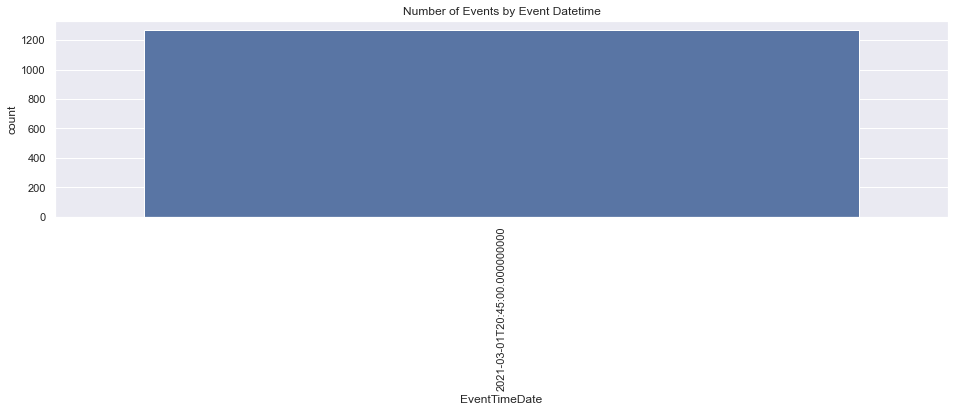

In [31]:
# Create a bar graph to show distribution of incidences of maternal death by region
fig, ax = plt.subplots(figsize=(16, 4))
plt.xticks(rotation='vertical')
plt.grid(True)
fig.subplots_adjust(bottom=0.2)
sns.countplot(cleaned_merged_df['EventTimeDate'])
plt.title('Number of Events by Event Datetime')
plt.show()

Observations: This needs to be assessed with more data. This exploration is briefly placed on hold until after the meeting with the Data Engineers to establish the most efficient pipeline to import GDELT's data (02 March 2021)

#### By Country

/Users/emily-work/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


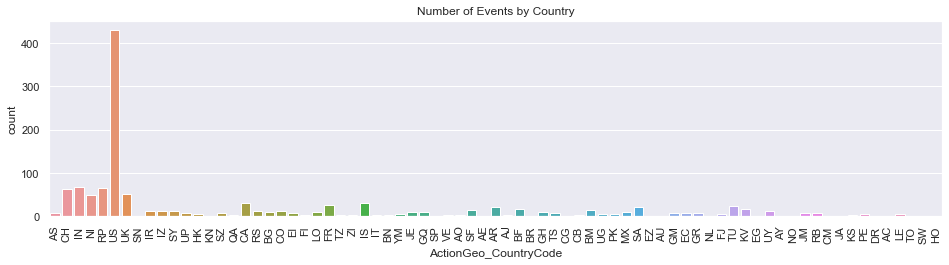

In [32]:
# Create a bar graph to show distribution of incidences of maternal death by region
fig, ax = plt.subplots(figsize=(16, 4))
plt.xticks(rotation='vertical')
plt.grid(True)
fig.subplots_adjust(bottom=0.2)
sns.countplot(cleaned_merged_df['ActionGeo_CountryCode'])
plt.title('Number of Events by Country')
plt.show()

Observations: While this needs to be assessed with more data, it appears that the US has substantially more records when compared to all other countries within this dataset. This exploration is briefly placed on hold until after the meeting with the Data Engineers to establish the most efficient pipeline to import GDELT's data (02 March 2021)

### Question 2: What is the Percentage of Events per QuadClass? What is the MODE Confidence and Tone per QuadClass?

#### Percentage of Events by QuadClass

In [60]:
# Create a sub-dataframe to group GLOBALEVENTID by QuadClass
quadclass = get_var_percentages(cleaned_merged_df, 'QuadClass')
quadclass

,GLOBALEVENTID,%
QuadClass,,
1,781,61.641673
2,160,12.628256
3,155,12.233623
4,171,13.496448


Observations: While this needs to be assessed with more data, it does appear that QuadClass 1, meaning Verbal Cooperation, is the most prevelant, followed by QuadClass 4, Material Cooperation. However, is based on the previous section, it would be worthwhile to remove US-associated events and re-assess. This exploration is briefly placed on hold until after the meeting with the Data Engineers to establish the most efficient pipeline to import GDELT's data (02 March 2021)

In [61]:
# Create a sub-dataframe to group GLOBALEVENTID by QuadClass without US 
non_us_df = cleaned_merged_df.loc[ cleaned_merged_df['ActionGeo_CountryCode'] != 'US' ]
non_us_quadclass = get_var_percentages(non_us_df, 'QuadClass')
non_us_quadclass

,GLOBALEVENTID,%
QuadClass,,
1,781,61.641673
2,160,12.628256
3,155,12.233623
4,171,13.496448


Observations: The propotions seemed to have remained roughly the same with a slight increase in QuadClass 1 and 4 and slight decreases in QuadClass 2 and 3. This exploration is briefly placed on hold until after the meeting with the Data Engineers to establish the most efficient pipeline to import GDELT's data (02 March 2021)

#### Mode of Confidence and MentionDocTone Values by QuadClass

In [53]:
# Create a sub-dataframe to group GLOBALEVENTID by QuadClass
quadclass_modes = cleaned_merged_df[['QuadClass','Confidence','MentionDocTone']
                                   ].groupby('QuadClass').agg(lambda x: pd.Series.mode(x)[0])
quadclass_modes

,Confidence,MentionDocTone
QuadClass,,
1,20.0,-4.883721
2,20.0,-4.848485
3,40.0,-2.465166
4,20.0,-5.102041


Observations: The propotions seemed to have remained roughly the same with a slight increase in QuadClass 1 and 4 and slight decreases in QuadClass 2 and 3. This exploration is briefly placed on hold until after the meeting with the Data Engineers to establish the most efficient pipeline to import GDELT's data (02 March 2021)

In [ ]:
# Number of/Percentage of events per QuadClass
# Number of/Percentages of events per EventType

### Question 2: What is the Percentage of Events per EventRootCode? What is the MODE Confidence and Tone per EventRootCode?

In [65]:
# Create a sub-dataframe to group GLOBALEVENTID by EventRootCode
cameoaction = get_var_percentages(cleaned_merged_df, 'EventRootCode')
cameoaction.sort_values(by='%', ascending=False)

,GLOBALEVENTID,%
EventRootCode,,
4,293,23.125493
5,166,13.101815
1,164,12.943962
2,94,7.419100
19,72,5.682715
11,67,5.288082
3,64,5.051302
7,59,4.656669
17,55,4.340963


Observations: This exploration is briefly placed on hold until after the meeting with the Data Engineers to establish the most efficient pipeline to import GDELT's data (02 March 2021)